In [11]:
import numpy as np
from scipy.linalg import sqrtm
import scipy as sc
import matplotlib.pyplot as plt
import scipy
import random
import numba as numba
from numpy import complex128
from math import comb
from numba.typed import Dict
from numba import types
from scipy.optimize import curve_fit
from torch.optim import lr_scheduler
import torch
from tqdm import tqdm
import time
import csv
qumodes_number=100

# SET DEVICE

In [12]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

cpu


# 1/2 first case Scenario (without entanglemets)

In [13]:
# parameters selection for the adv equation
options=torch.Tensor([.1,.2,.3,.4,.5,.6,.7,.8,.9,1,1.1])
alphas=torch.randint(size=(1,qumodes_number),high=len(options)).reshape(-1).to(torch.float64)
for dimension in range(qumodes_number):
    alphas[dimension]=options[int(alphas[dimension])]

In [14]:
#grid parameters
a=-15
b=-a
N=2**7
dx=(b-a)/N

In [15]:
#initials for each dimension (coherent states)
w=1
h=2
t=1
coherent_alphas=((torch.rand(qumodes_number)+1j*torch.rand(qumodes_number))-0.5)*5
def coherent_state(x,alpha):
    return np.power((w/(h*np.pi)),0.25)*np.exp(-np.abs(alpha)**2/2)*np.exp(x**2*np.sqrt(w/h)**2/2-(x*np.sqrt(w/h)-alpha/np.sqrt(2))**2)

initials=torch.stack([coherent_state(torch.linspace(a,b,N).reshape(-1,1), alpha_i) for alpha_i in coherent_alphas])

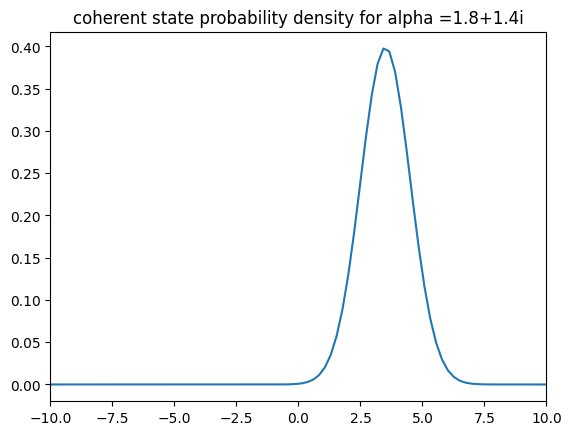

In [16]:
plt.plot(torch.linspace(a,b,N),torch.abs(coherent_state(torch.linspace(a,b,N),coherent_alphas[0]))**2)
plt.xlim(-10,10)
plt.title("coherent state probability density for alpha ="+str(np.round(np.real(coherent_alphas[0].item()),1))+"+"+str(np.round(np.imag(coherent_alphas[0].item()),1))+"i")
plt.show()

In [17]:
#EVOLUTION operators
p=torch.zeros((N,N),dtype=torch.complex64)
for i in range(N):
    if i!=0:
        p[i][i-1]=1j*h/(2*dx)
    if i!=N-1:
        p[i][i+1]=-1j*h/(2*dx)
p[0][N-1]=1j*h/dx
p[N-1][0]=-1j*h/dx


Unitary_evol_operators=[torch.matrix_exp(-1j*p*t*alphas[i]/h) for i in range(qumodes_number)] # 100 128*128 Matrixes

In [18]:
#EVOLUTION process

states_after_evolution_1=[Unitary_evol_operators[i]@initials[i] for i in range(qumodes_number)] # 100 128*1 vectors

In [27]:
#CLASSICAL VALIDATION
N_t=1000
dt=t/N_t

classical_solutions_1=[]
for s,alpha in tqdm(enumerate(alphas)):
    
    A=torch.zeros(N,N).to(DEVICE).to(torch.complex64) 
    for i in range(N):
        A[i][i]=1-alpha*dt/dx
        if i!=N-1:
            A[i][i+1]=alpha*dt/dx
    A[N-1][0]=alpha*dt/dx
    A_1=torch.linalg.inv(A)
    V=initials[s].to(DEVICE)
    for nt in range(N_t):
        V=A_1@V
    V/=torch.sqrt((torch.abs(V)**2*dx).sum())
    classical_solutions_1+=[V]

100it [00:00, 104.75it/s]


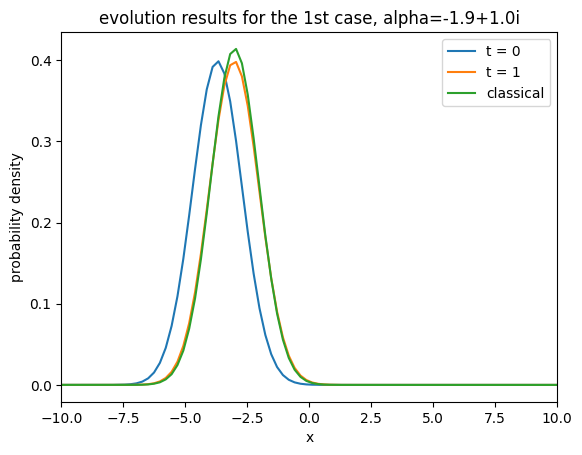

In [28]:
#CHOOSE s to plot a state
s=51
plt.plot(torch.linspace(a,b,N),torch.abs(coherent_state(torch.linspace(a,b,N),coherent_alphas[s]))**2)
plt.plot(torch.linspace(a,b,N),torch.abs(states_after_evolution_1[s].T.conj()[0])**2)

plt.plot(torch.linspace(a,b,N),torch.abs(classical_solutions_1[s].cpu())**2)
plt.xlim(-10,10)
plt.title("evolution results for the 1st case, alpha="+str(np.round(np.real(coherent_alphas[s].item()),1))+"+"+str(np.round(np.imag(coherent_alphas[s].item()),1))+"i")
plt.legend(["t = 0","t = "+str(t),"classical"])
plt.xlabel("x")
plt.ylabel("probability density")
plt.show()

# 3/4 second case Scenario (with entanglemets)